In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate


In [28]:
# Load the Netflix dataset
netflix_dataset = pd.read_csv("combined_data_1.txt", header=None, names=["Cust_Id", "Rating"], usecols=[0,1])

# Add a Movie_Id column placeholder
netflix_dataset['Movie_Id'] = np.nan

In [29]:
netflix_dataset

,Cust_Id,Rating,Movie_Id
0,1:,NaN,NaN
1,1488844,3.0,NaN
2,822109,5.0,NaN
3,885013,4.0,NaN
4,30878,4.0,NaN
...,...,...,...
24058258,2591364,2.0,NaN
24058259,1791000,2.0,NaN
24058260,512536,5.0,NaN
24058261,988963,3.0,NaN


In [30]:
# Find indices where Rating is NaN (movie separators)
df_nan = pd.DataFrame(pd.isnull(netflix_dataset.Rating))
df_nan = df_nan[df_nan['Rating'] == True]

movie_np = []
movie_id = 1

for i, j in zip(df_nan.index[1:], df_nan.index[:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Append for last movie
last_record = len(netflix_dataset) - df_nan.index[-1] - 1
movie_np = np.append(movie_np, np.full((1, last_record), movie_id))

# Assign Movie_Id column
netflix_dataset = netflix_dataset[pd.notnull(netflix_dataset['Rating'])]
netflix_dataset['Movie_Id'] = movie_np.astype(int)
netflix_dataset['Cust_Id'] = netflix_dataset['Cust_Id'].astype(int)
netflix_dataset['Rating'] = netflix_dataset['Rating'].astype(int)


C:\Users\ag168\AppData\Local\Temp\ipykernel_20228\2809292292.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_dataset['Movie_Id'] = movie_np.astype(int)
C:\Users\ag168\AppData\Local\Temp\ipykernel_20228\2809292292.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_dataset['Cust_Id'] = netflix_dataset['Cust_Id'].astype(int)
C:\Users\ag168\AppData\Local\Temp\ipykernel_20228\2809292292.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [33]:
netflix_dataset

,Cust_Id,Rating,Movie_Id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
24058258,2591364,2,4499
24058259,1791000,2,4499
24058260,512536,5,4499
24058261,988963,3,4499


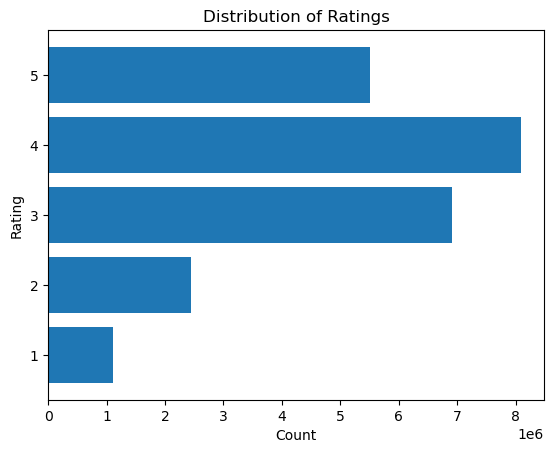

In [34]:
stars = netflix_dataset.groupby('Rating')['Rating'].agg(['count'])
plt.barh(stars.index, stars['count'])
plt.xlabel("Count")
plt.ylabel("Rating")
plt.title("Distribution of Ratings")
plt.show()


In [35]:
f = ['count','mean']

# Movie popularity
dataset_movie_summary = netflix_dataset.groupby('Movie_Id')['Rating'].agg(f)
movie_benchmark = dataset_movie_summary['count'].quantile(0.7)
drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

# User activity
dataset_cust_summary = netflix_dataset.groupby('Cust_Id')['Rating'].agg(f)
cust_benchmark = dataset_cust_summary['count'].quantile(0.7)
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index

# Apply filter
print("Before Trim:", netflix_dataset.shape)
netflix_dataset = netflix_dataset[~netflix_dataset['Movie_Id'].isin(drop_movie_list)]
netflix_dataset = netflix_dataset[~netflix_dataset['Cust_Id'].isin(drop_cust_list)]
print("After Trim:", netflix_dataset.shape)


Before Trim: (24053764, 3)
After Trim: (17337458, 3)


In [39]:
drop_cust_list

Index([      8,      10,      25,      33,      42,      59,      83,      87,
            94,     116,
       ...
       2649343, 2649351, 2649375, 2649376, 2649379, 2649384, 2649401, 2649404,
       2649409, 2649421],
      dtype='int32', name='Cust_Id', length=327300)

In [37]:
cust_benchmark

52.0

In [36]:
dataset_cust_summary

,count,mean
Cust_Id,,
6,153,3.333333
7,195,4.066667
8,21,4.000000
10,49,3.346939
25,4,3.500000
...,...,...
2649404,12,4.083333
2649409,10,4.000000
2649421,3,5.000000


In [40]:
# Take a sample for training speed
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(netflix_dataset[['Cust_Id','Movie_Id','Rating']].sample(100000, random_state=42), reader)

# Train/Test cross-validation
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'], cv=3, verbose=True)

# Fit full model for predictions
trainset = data.build_full_trainset()
svd.fit(trainset)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9985  1.0020  1.0010  1.0005  0.0015  
MAE (testset)     0.8028  0.8069  0.8031  0.8043  0.0019  
Fit time          1.05    0.90    1.02    0.99    0.07    
Test time         0.18    0.36    0.16    0.23    0.09    


In [41]:
# Load movie titles safely (handle commas in movie names)
df_title = pd.read_csv(
    "movie_titles.csv",
    encoding="ISO-8859-1",
    header=None,
    names=["Movie_Id", "Year", "Name"],
    quotechar='"',        # treat quoted text as a single field
    on_bad_lines="skip"   # skip malformed rows if any
)

df_title.set_index("Movie_Id", inplace=True)
print("Movies loaded:", df_title.shape)
df_title.head()



Movies loaded: (17434, 2)


,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [43]:
def recommend_for_user(user_id, n=10):
    # Movies the user already rated
    seen_movies = set(netflix_dataset.loc[netflix_dataset['Cust_Id'] == user_id, 'Movie_Id'])
    
    # Candidate movies (not seen & not dropped)
    candidates = df_title.copy().reset_index()
    candidates = candidates[~candidates['Movie_Id'].isin(seen_movies)]
    candidates = candidates[~candidates['Movie_Id'].isin(drop_movie_list)]
    
    # Predict scores
    candidates['Estimate_Score'] = candidates['Movie_Id'].apply(lambda x: svd.predict(user_id, x).est)
    
    # Top-N recommendations
    top_recs = candidates.sort_values('Estimate_Score', ascending=False).head(n)
    return top_recs[['Movie_Id','Name','Estimate_Score']]

# Example: Recommend for user 712664
recommend_for_user(1331154, n=5)


,Movie_Id,Name,Estimate_Score
3391,3456,Lost: Season 1,4.785576
2990,3046,The Simpsons: Treehouse of Horror,4.632834
2067,2102,The Simpsons: Season 6,4.604835
1231,1256,The Best of Friends: Vol. 4,4.547200
2078,2114,Firefly,4.541630
